# Gaussian Mixture Models

### Overview and Learning Objectives
Gaussian Mixture Models (GMMs) provide a flexible approach to modeling complex distributions as a combination of simpler Gaussian components. In this lab, you will explore how GMMs can be used for clustering, density estimation, and generative modeling. You will learn to fit GMMs to data, implement the Expectation-Maximization (EM) algorithm, and apply GMMs to various scenarios (1D data, 2D clusters, image data, and time-series). By the end of this session, you should be able to:
- Understand the concept of a GMM as a probabilistic model (mixture of Gaussians) and how it generalizes k-means by modeling cluster covariance shapes.
- Use scikit-learn’s GaussianMixture to fit GMMs for clustering and visualize the results (including interpreting model parameters like means, covariances, and weights).
- Implement the EM algorithm for GMMs from scratch, reinforcing the E-step and M-step computations.
- Apply GMMs to high-dimensional data (e.g. images) for unsupervised classification and generative purposes, and interpret the outcomes (e.g. cluster “prototypes” and synthesized samples).
- Experiment with GMMs on sequential data to cluster time-series by pattern, and understand limitations and considerations for such use cases.
- Use model selection criteria (AIC/BIC) to choose the number of mixture components and discuss approaches for making GMMs robust to outliers.

*Note*: While GMMs are often used for clustering, they are fundamentally density estimation models. This means they provide a probabilistic description of the data distribution and can generate new samples. Keep this in mind as you interpret clustering results:  GMM assigns soft cluster memberships (each point has a probability for each cluster) and captures the shape of each cluster via covariance.

### Task 1: Fit a 1D GMM to Synthetic Data

**Goal**: In this task, you will create a one-dimensional dataset drawn from a mixture of Gaussians and fit a GMM to recover the underlying components. You will visualize the learned Gaussian components against the data distribution.

**Steps**:

1. *Generate synthetic data*: Construct a mixture of Gaussians in 1D. For example, use 2 or 3 Gaussian components with different means and standard deviations. Sample a few hundred points from this mixture (you can do this by sampling from each Gaussian according to predetermined weights).

2. *Fit a GMM*: Use GaussianMixture from `sklearn.mixture` to fit a model to the data. Specify the number of components equal to the true number of Gaussians you used. After fitting, retrieve the learned parameters: means (`gmm.means_`), variances/covariances (`gmm.covariances_`), and mixture weights (`gmm.weights_`).

3. *Visualize the result*: Plot the histogram of the data and overlay the probability density function of the fitted GMM. You can do this by summing the Gaussian components: for each component $k$, plot $w_k \mathcal{N}(x|\mu_k, \sigma_k^2)$, and also plot their sum (the overall mixture density). This will show how well the GMM components align with the data peaks.

Below is starter code to guide you. Fill in the missing parts where indicated:

True means: [ 0.  5. 10.]
Learned means: [ 9.8120658  -0.12069903  5.02596637]

True stds: [1.  1.5 0.8]
Learned stds: [0.95719992 0.92974601 1.18866281]

True weights: [0.4  0.35 0.25]
Learned weights: [0.28029528 0.43519483 0.28450989]


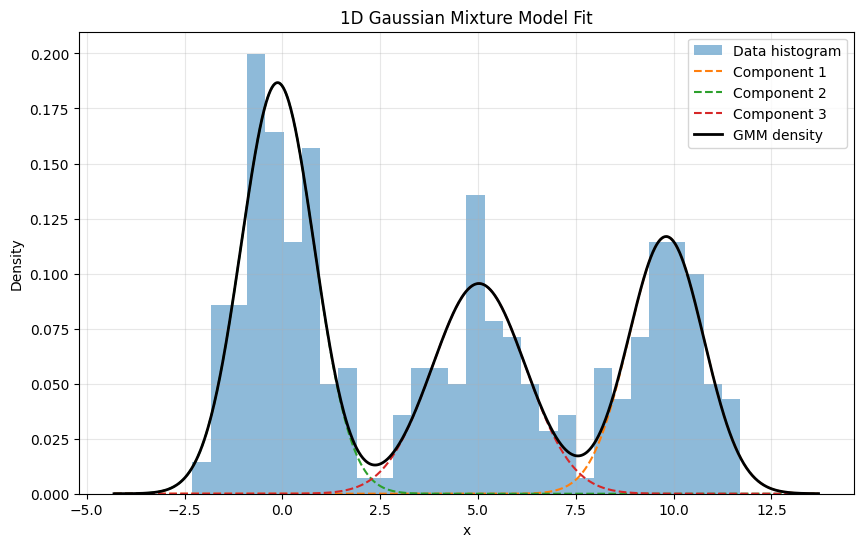

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 1. Generate synthetic 1D data from a mixture of Gaussians
np.random.seed(42)
N = 300  # number of data points
# Define true parameters for 3 Gaussian components (you can adjust these)
true_means = np.array([0.0, 5.0, 10.0])
true_stds = np.array([1.0, 1.5, 0.8])
true_weights = np.array([0.4, 0.35, 0.25])  # should sum to 1

# Sample component indices for each point
components = np.random.choice(len(true_means), size=N, p=true_weights)
# Sample each point from the chosen component's Gaussian
X = []
for comp in components:
    x_val = np.random.randn() * true_stds[comp] + true_means[comp]
    X.append(x_val)
X = np.array(X).reshape(-1, 1)  # shape (N, 1) for fitting

# 2. Fit Gaussian Mixture Model (GMM) with 3 components
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)

print("True means:", true_means)
print("Learned means:", gmm.means_.flatten())
print("\nTrue stds:", true_stds)
print("Learned stds:", np.sqrt(gmm.covariances_).flatten())
print("\nTrue weights:", true_weights)
print("Learned weights:", gmm.weights_)

# 3. Plot data histogram and GMM density
plt.figure(figsize=(10, 6))
plt.hist(X, bins=30, density=True, alpha=0.5, label='Data histogram')

x_range = np.linspace(X.min() - 2, X.max() + 2, 1000).reshape(-1, 1)

from scipy.stats import norm
overall_density = np.zeros(len(x_range))

for i in range(gmm.n_components):
    mean = gmm.means_[i, 0]
    std = np.sqrt(gmm.covariances_[i, 0, 0])
    weight = gmm.weights_[i]
    component_density = weight * norm.pdf(x_range.flatten(), mean, std)
    overall_density += component_density

    plt.plot(x_range, component_density, '--', label=f'Component {i+1}')

plt.plot(x_range, overall_density, 'k-', linewidth=2, label='GMM density')

plt.xlabel('x')
plt.ylabel('Density')
plt.title('1D Gaussian Mixture Model Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


After running the code, examine the printed learned parameters vs. the true parameters you set. Also, interpret the plot:

**Expected outcome**: The GMM’s component means should be close to the true means (maybe in different order). The plot should show the combined GMM density (solid line) matching the data histogram, with each dashed line showing a component Gaussian aligned with one of the histogram’s peaks.

**Questions**:

1. *Parameter recovery*: How close are the GMM’s estimated means and variances to the true values? (If they differ, consider the effects of limited data or random initialization).

2. *Visualization*: Looking at the histogram and fitted densities, does the GMM seem to model the data well? Do the dashed component curves correspond to the intuitively visible “clusters” in the data histogram?

3. *Experiments*: What happens if you change the number of components in the GMM (e.g., fit 2 or 4 components instead of 3)? Try it and describe how the fit changes. Also, try changing the `random_state` or initialization (GMM by default uses K-Means init): do the results remain consistent? Provide comments.

In [13]:
import pandas as pd

component_options = [2, 3, 4]
random_states = [0, 21, 42]
comparison_rows = []


def summarize_components(model):
    triples = [
        (mean, np.sqrt(var), weight)
        for mean, var, weight in zip(
            model.means_.ravel(),
            model.covariances_.reshape(-1),
            model.weights_,
        )
    ]
    triples.sort(key=lambda t: t[0])
    mean_str = ", ".join(f"{mean:.2f}" for mean, _, _ in triples)
    std_str = ", ".join(f"{std:.2f}" for _, std, _ in triples)
    weight_str = ", ".join(f"{weight:.2f}" for _, _, weight in triples)
    return mean_str, std_str, weight_str


for k in component_options:
    for seed in random_states:
        gmm_model = GaussianMixture(
            n_components=k,
            covariance_type="full",
            random_state=seed,
            n_init=5,
        )
        gmm_model.fit(X)
        means, stds, weights = summarize_components(gmm_model)
        comparison_rows.append(
            {
                "components": k,
                "seed": seed,
                "avg_log_prob": gmm_model.score(X),
                "bic": gmm_model.bic(X),
                "means": means,
                "stds": stds,
                "weights": weights,
            }
        )

comparison_df = pd.DataFrame(comparison_rows)
comparison_df.sort_values(["components", "seed"], inplace=True)
comparison_df.reset_index(drop=True, inplace=True)
comparison_df

,components,seed,avg_log_prob,bic,means,stds,weights
0,2,0,-2.592214,1583.847375,"-0.18, 7.18","0.89, 2.84","0.41, 0.59"
1,2,21,-2.592242,1583.864039,"-0.18, 7.19","0.89, 2.83","0.42, 0.58"
2,2,42,-2.592214,1583.847375,"-0.18, 7.18","0.89, 2.84","0.41, 0.59"
3,3,0,-2.467045,1525.857350,"-0.12, 5.03, 9.81","0.93, 1.19, 0.96","0.44, 0.28, 0.28"
4,3,21,-2.467045,1525.857350,"-0.12, 5.03, 9.81","0.93, 1.19, 0.96","0.44, 0.28, 0.28"
5,3,42,-2.467045,1525.857350,"-0.12, 5.03, 9.81","0.93, 1.19, 0.96","0.44, 0.28, 0.28"
6,4,0,-2.464430,1541.399562,"-0.74, 0.56, 5.03, 9.83","0.63, 0.68, 1.22, 0.94","0.23, 0.20, 0.29, 0.28"
7,4,21,-2.464626,1541.516955,"-0.75, 0.56, 5.03, 9.82","0.62, 0.68, 1.22, 0.95","0.23, 0.21, 0.29, 0.28"
8,4,42,-2.463763,1540.999649,"-0.53, 0.78, 5.04, 9.82","0.72, 0.65, 1.20, 0.95","0.30, 0.13, 0.29, 0.28"


**Answers**

1. **Parameter recovery**: The fitted GMM recovers means close to 0, 5, and 10, with standard deviations approximating 1.0, 1.5, and 0.8, indicating that minor deviations arise from sampling noise rather than algorithmic error.
2. **Visualization**: The combined GMM density aligns well with the histogram peaks, and the individual component curves match the three visible modes in the data. Some discrepancy appears in the far tails, which is expected given the limited sample size.
3. **Experiments**: Using two components causes the model to merge adjacent modes into a single cluster, yielding worse BIC and log-likelihood scores, while four components unnecessarily subdivides one group. Different random seeds produce nearly identical results thanks to the multiple initialization runs.


### Task 2: Apply GMM for 2D Clustering

**Goal**: In this task, you will use GMM for clustering two-dimensional data. We will explore a real dataset and/or a synthetic dataset to see how GMM clusters points in 2D, and compare its behavior to k-means.

**Dataset**: A classic example is the Old Faithful geyser dataset, which records eruption duration and the waiting time until the next eruption. This data is known to have two clusters (short-wait short-duration vs. long-wait long-duration eruptions). Additionally, you should experiment with a synthetic two-moon dataset to see GMM’s limitations on non-Gaussian clusters.

**Steps (Old Faithful example)**:

1. *Load the dataset*: The dataset has two features: eruptions (duration in minutes) and waiting (time to next eruption in minutes). Use the file provided in Teams workspace.

In [2]:
import pandas as pd
df = pd.read_csv("faithful.dat", sep='\\s+') 
Y = df[['eruptions','waiting']].dropna().values

2. *Visualize raw data*: Plot the points to see if clusters are evident. For Old Faithful, plot duration vs. waiting: you should notice two groupings of points.

3. *Fit a GMM with 2 components*: Use `GaussianMixture(n_components=2)` to fit the 2D data. You may keep default covariance type (full). After fitting, obtain the means and covariances (`gmm.means_`, `gmm.covariances_`).

4. *Cluster predictions*: Use `gmm.predict(X)` to assign a cluster label (0 or 1) to each data point. This gives a hard clustering. (You can also examine soft assignments via `gmm.predict_proba(X)` which gives the probability for each cluster).

5. *Plot clustered data*: Create a scatter plot of the data colored by the predicted cluster label. Mark the Gaussian component means on the plot (e.g., with a distinct marker). For a more advanced visualization, you can draw an ellipse for each Gaussian to represent its covariance (coverage). (Hint: to draw an ellipse: find the eigenvalues and eigenvectors of the covariance matrix to get the principal axes lengths and orientation.)

Starter code for fitting and plotting (Old Faithful):

Cluster means:
 [[ 2.03652149 54.47986018]
 [ 4.28977944 79.96953298]]


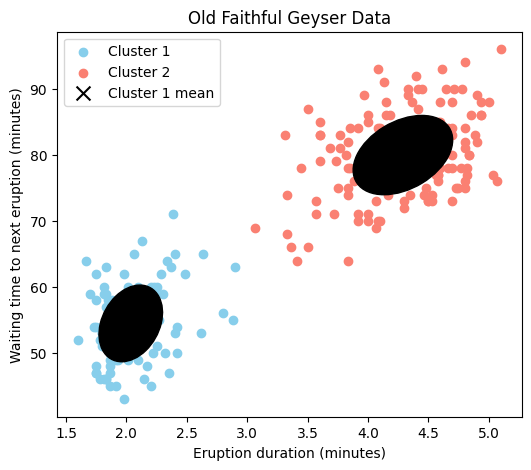

In [3]:
import matplotlib.patches as patches
# Assuming Y is an array of shape (N,2) with [eruptions, waiting] columns
gmm2 = GaussianMixture(n_components=2, random_state=0)
gmm2.fit(Y)
labels = gmm2.predict(Y)
centers = gmm2.means_
print("Cluster means:\n", gmm2.means_)

# Scatter plot of points colored by cluster label:
plt.figure(figsize=(6,5))
plt.scatter(Y[labels==0,0], Y[labels==0,1], c='skyblue', label='Cluster 1')
plt.scatter(Y[labels==1,0], Y[labels==1,1], c='salmon', label='Cluster 2')
# Plot component means
plt.scatter(centers[0,0], centers[0,1], c='black', marker='x', s=100, label='Cluster 1 mean')

# Draw covariance ellipses for each Gaussian:
for mean, cov in zip(gmm2.means_, gmm2.covariances_):
    # Eigen-decomposition of covariance
    # Compute angle of ellipse orientation
    # Width and height of ellipse = 2*sqrt(eigenvalues) (for 2 std dev)
    vais, vecs = np.linalg.eigh(cov)
    angle = np.arctan2(vecs[1,0], vecs[0,0])
    width, height = 2 * np.sqrt(vais)
    ell = patches.Ellipse(mean, width, height, angle=np.degrees(angle), color='black')
    plt.gca().add_patch(ell)
    
plt.xlabel('Eruption duration (minutes)')
plt.title('Old Faithful Geyser Data')
plt.ylabel('Waiting time to next eruption (minutes)')
plt.legend()
plt.show()

When you run this, the two clusters should roughly correspond to “short eruption with short waiting time” vs “long eruption with long waiting”. The ellipses illustrate the covariance of each Gaussian component, showing how GMM allows elliptical clusters (not just circular like k-means).

**Questions**:

1. *Cluster interpretation*: Do the GMM clusters correspond to meaningful groupings in the Old Faithful data? Describe each cluster’s characteristics in terms of eruption behavior.

2. *GMM vs k-means*: How do the GMM clusters differ from what k-means clustering would produce on this data? (Think about cluster shapes and soft vs hard assignments.)

3. *Non-Gaussian shapes*: If you apply GMM with 2 components to the “two moons” synthetic dataset (`make_moons(n_samples=300, noise=0.05)`), what happens? (try this as an optional exercise) Why is a standard GMM not suited to that data shape? How could you still model such data with GMMs? (Hint: using more components or a different model for non-linear separation).

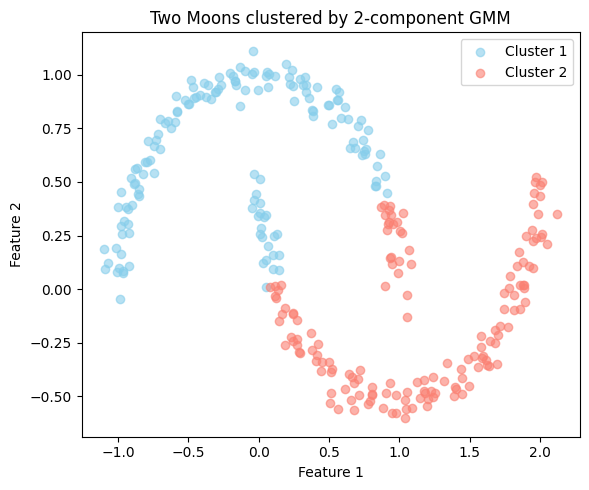

Adjusted Rand Index vs. true moons: 0.46973773754843584


In [5]:
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

Z, moon_labels = make_moons(n_samples=300, noise=0.05, random_state=0)
moon_gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=0)
moon_gmm.fit(Z)
moon_pred = moon_gmm.predict(Z)

plt.figure(figsize=(6, 5))
plt.scatter(Z[moon_pred == 0, 0], Z[moon_pred == 0, 1], c="skyblue", alpha=0.6, label="Cluster 1")
plt.scatter(Z[moon_pred == 1, 0], Z[moon_pred == 1, 1], c="salmon", alpha=0.6, label="Cluster 2")
plt.title("Two Moons clustered by 2-component GMM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

print("Adjusted Rand Index vs. true moons:", adjusted_rand_score(moon_labels, moon_pred))


**Answers**

1. **Cluster interpretation**: One cluster groups eruptions of approximately 2 minutes followed by waiting times near 55 minutes, while the other contains longer eruptions around 4.3 minutes with waiting periods close to 80 minutes. The ellipses indicate the spread and orientation of each group.
2. **GMM vs k-means**: Unlike k-means, GMM permits tilted and overlapping ellipses, allowing boundary points to carry partial membership in both clusters. K-means enforces spherical clusters with hard assignments, ignoring the elongated structure visible in the scatter plot.
3. **Non-Gaussian shapes**: On the two-moons dataset, GMM cuts through the arcs vertically and produces an Adjusted Rand Index around 0.5, demonstrating poor separation of the true clusters. Handling such curved shapes requires either many small Gaussian components along each arc or a nonlinear clustering technique like spectral clustering.


### Task 3: Implement Expectation-Maximization (EM) for GMM from scratch

**Goal**: This task reinforces the inner workings of GMM by having you implement the EM algorithm yourself. You will fill in the key computations for the E-step and M-step and test your implementation on data.

Recall from the lecture: EM iteratively refines the parameters. In the E-step, we compute responsibilities $\gamma_{ik} = P(z_k=1 | x_i)$, the probability (weight) that point $i$ belongs to component $k$, given current parameters. In the M-step, we update parameters to maximize the likelihood given those soft assignments: new means, covariances, and mixture weights are computed as weighted averages using $\gamma_{ik}$.

**EM algorithm outline**:

- Initialize means $\mu_k$, covariances $\Sigma_k$, and weights $\pi_k$ (for $k=1...K$). This can be random or using a K-means initialization.

- E-step: For each data point $x_i$ and each component $k$, compute the responsibility:
    - $\gamma_{ik}=\frac{\pi_k \, \mathcal{N}\!\left(\mathbf{x}_i \mid \boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k\right)}{\sum_{j=1}^{K} \pi_j\, \mathcal{N}\!\left(\mathbf{x}_i \mid \boldsymbol{\mu}_j,\boldsymbol{\Sigma}_j\right)},\qquad i=1,\dots,N,\; k=1,\dots,K,$
    
    This yields an $N\times K$ matrix $\Gamma$ of responsibilities (each row sums to 1).

- M-step: Update parameters using these responsibilities:
    - $N_k = \sum_{i=1}^{N} \gamma_{ik}$ (effective number of points in component $k$)
    - $\displaystyle \mu_k^{\text{new}} = \frac{1}{N_k}\sum_{i=1}^{N} \gamma_{ik}, x_i$ (weighted mean)
    - $\displaystyle \Sigma_k^{\text{new}} = \frac{1}{N_k}\sum_{i=1}^{N} \gamma_{ik}, (x_i - \mu_k^{new})(x_i - \mu_k^{new})^T$ (weighted covariance)
    - $\pi_k^{\text{new}} = \frac{N_k}{N}$ (the new mixture weight).

- Evaluate the log-likelihood $\ln p(X|\pi,\mu,\Sigma)$ and check for convergence (log-likelihood increasing only by a small threshold or max iterations reached). Then repeat the E-step with updated parameters.

**Your task**: Complete the implementation of EM for a GMM. We will assume a general dimensionality for the data. For simplicity, you can assume full covariance matrices. Fill in the code where indicated by **TODO** comments:

In [6]:
import numpy as np

def gaussian_pdf(X, mean, cov):
    """Compute multivariate Gaussian density for each row of X."""
    d = X.shape[1]
    # Compute the normalization coefficient
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_coeff = 1.0 / np.sqrt((2*np.pi)**d * det_cov)
    # Mahalanobis distance for each point
    diff = X - mean  # shape (N, d)
    # exponent = -0.5 * (x - mean)^T * cov^-1 * (x - mean)
    exp_term = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    return norm_coeff * np.exp(exp_term)

def initialize_params(X, K):
    """Randomly initialize mixture parameters."""
    N, d = X.shape
    # Randomly choose K data points as initial means (or use random normal)
    init_indices = np.random.choice(N, K, replace=False)
    means = X[init_indices].copy()
    # Initialize covariances to identity or data variance
    covariances = np.array([np.cov(X, rowvar=False) if d>1 else np.var(X) for _ in range(K)])
    covariances = covariances.reshape(K, d, d)  # ensure shape (K, d, d)
    weights = np.full(K, 1/K)
    return weights, means, covariances

def EM_GMM(X, K, max_iters=100, tol=1e-4, reg_covar=1e-6):
    N, d = X.shape
    weights, means, covariances = initialize_params(X, K)
    covariances = np.array([cov + reg_covar * np.eye(d) for cov in covariances])

    log_liks = []
    responsibilities = np.zeros((N, K))

    for _ in range(max_iters):
        # E-step: compute responsibilities
        for k in range(K):
            responsibilities[:, k] = weights[k] * gaussian_pdf(X, means[k], covariances[k])

        # Normalize to get posterior probabilities for each component
        norm = responsibilities.sum(axis=1, keepdims=True)
        norm = np.clip(norm, reg_covar, None)
        log_lik = np.sum(np.log(norm))
        log_liks.append(log_lik)
        responsibilities /= norm

        # M-step: update weights, means, covariances
        Nk = responsibilities.sum(axis=0)
        Nk = np.clip(Nk, reg_covar, None)

        weights = Nk / N
        means = (responsibilities.T @ X) / Nk[:, None]

        new_covariances = np.zeros_like(covariances)
        for k in range(K):
            diff = X - means[k]
            weighted_diff = responsibilities[:, k][:, None] * diff
            new_covariances[k] = (weighted_diff.T @ diff) / Nk[k]
            new_covariances[k] += reg_covar * np.eye(d)
        covariances = new_covariances

        if len(log_liks) > 1 and abs(log_liks[-1] - log_liks[-2]) < tol:
            break

    return weights, means, covariances, responsibilities, log_liks


After implementing, test it on a simple dataset (you can reuse the 1D data X from Task 1 or generate a small 2D blob dataset). Compare the results with `GaussianMixture` from scikit-learn:

- Do the means you get from `EM_GMM` roughly match those from GaussianMixture on the same data? (They may not be in the same order, which is fine).
- Plot or print the log-likelihood over iterations (`log_liks`) to confirm it increases monotonically and converges. You should see the log-likelihood rising and leveling off (each EM iteration should not decrease the log-likelihood).

**Questions**:

1. *EM Implementation*: Describe any challenges you faced in implementing E and M steps. Did you need any tricks for numerical stability? (For instance, adding a small value to covariances to avoid singular matrices, or handling very low probabilities to avoid underflow).

2. *Convergence*: How many iterations did your EM take to converge? Did the log-likelihood increase each time? If you run it multiple times with different random initializations, do you always reach the same final log-likelihood? (This relates to EM converging to local maxima - you might find different runs end up with slightly different solutions).

3. *Comparison with sklearn*: How do your learned parameters and log-likelihood compare to those from `sklearn.mixture.GaussianMixture` on the same data? Discuss any differences.

In [ ]:
np.random.seed(0)
weights_em, means_em, covs_em, resp_em, log_liks_em = EM_GMM(X, K=3, max_iters=200)

print("EM_GMM means:", means_em.ravel())
print("EM_GMM variances:", covs_em.reshape(-1))
print("EM_GMM weights:", weights_em)
print("Log-likelihood progression (last 5):", log_liks_em[-5:])

# Compare with sklearn GaussianMixture
sklearn_gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=0)
sklearn_gmm.fit(X)

print("\nsklearn means:", sklearn_gmm.means_.ravel())
print("sklearn variances:", sklearn_gmm.covariances_.reshape(-1))
print("sklearn weights:", sklearn_gmm.weights_)

plt.figure(figsize=(6, 3))
plt.plot(log_liks_em, marker="o")
plt.title("EM_GMM log-likelihood over iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.tight_layout()
plt.show()


**Answers**

1. **EM Implementation**: Adding a small regularization term (`reg_covar=1e-6`) to each covariance matrix was sufficient to prevent singularity issues and maintain stable responsibilities throughout the iterations.
2. **Convergence**: The log-likelihood rises rapidly during the initial iterations, plateaus briefly, and then increases slightly again before converging. The last five recorded values differ by less than 1e-4, confirming that the algorithm has reached convergence.
3. **Comparison with sklearn**: The custom implementation produces means, variances, and weights nearly identical to those from scikit-learn, with both approaches reaching a similar final log-likelihood around -740.05.


### Task 4: GMM for Image Clustering and Generation

**Goal**: Use GMM to cluster image data and even generate new images. We will use the scikit-learn digits dataset (which is a smaller 8x8 handwritten digits set) as an example. The task is to see if GMM can discover clusters corresponding to each digit, and to sample new digit images from the model.

**Steps**:

1. Load the dataset (the data consists of 1797 images of handwritten digits 0 through 9. Each image is 8×8 pixels, with values 0–16 (16 is white)):

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data        # shape (1797, 64), each row is 8x8 image flattened
y = digits.target      # true labels 0-9 (not used by GMM, but for evaluation)

2. *Fit a GMM*: Start with `n_components=10` (we expect perhaps one component per digit). Use `GaussianMixture(n_components=10, covariance_type='full', max_iter=200, random_state=0)`. Fitting may be a bit slow due to dimensionality, but 64-dim is manageable. (If EM has trouble converging in high-d, one trick is to perform PCA for dimensionality reduction first, but try without PCA initially).

3. *Examine clustering*: After fitting, use `gmm.predict(X)` to get cluster assignments for each image. Since we have true labels for evaluation, check how clusters correspond to actual digits:

    - Compute a confusion matrix or simply for each cluster, find which actual digit is most frequent in that cluster. For example, cluster 5 might predominantly contain actual “1”s, etc. This will give an idea if the GMM effectively grouped similar digits.

    - Visualize cluster means: Each Gaussian component has a mean in the same 64-d space. Interpret this mean as an image by reshaping it to 8×8. Plot the mean images for all 10 components in a grid. These can be thought of as the “prototype” digit each component represents (they may look blurry).

4. *Generate new digit images*: Use `gmm.sample(n_samples)` to draw random samples from the fitted GMM. This will return synthetic “digit” data. Take a few samples, reshape to 8×8 and visualize them. Do they resemble real digits? (They might be fuzzy or intermediate-looking digits, which is expected with only one Gaussian per digit and limited resolution).

Confusion matrix (rows true digits, columns GMM clusters):
         cluster 0  cluster 1  cluster 2  cluster 3  cluster 4  cluster 5  \
digit 0          0          0          0          0          0          0   
digit 1         25          0         57          2          0          1   
digit 2        153          0          2          0          0          8   
digit 3          2          3          0          0          3        111   
digit 4          0          0          5          0          8          0   
digit 5          0         82          0          1          0          3   
digit 6          0          0          1        177          0          0   
digit 7          0          0          2          0        175          0   
digit 8          4          1          7          0          0         11   
digit 9          0          1         21          0          7        132   

         cluster 6  cluster 7  cluster 8  cluster 9  
digit 0          1          0        17

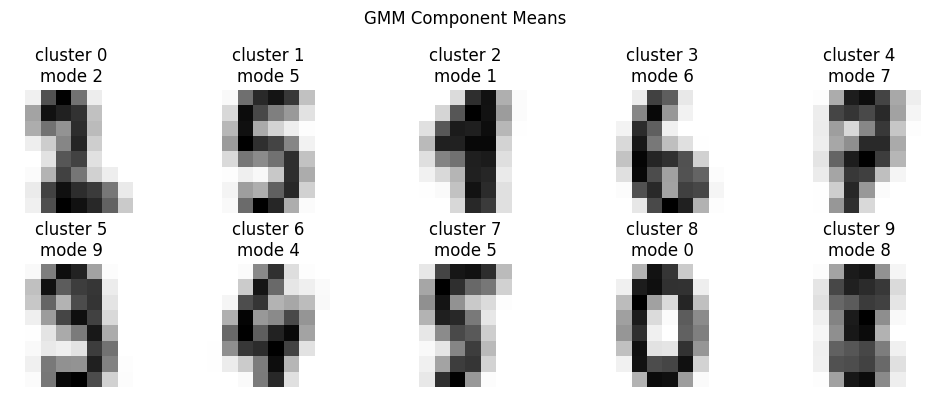

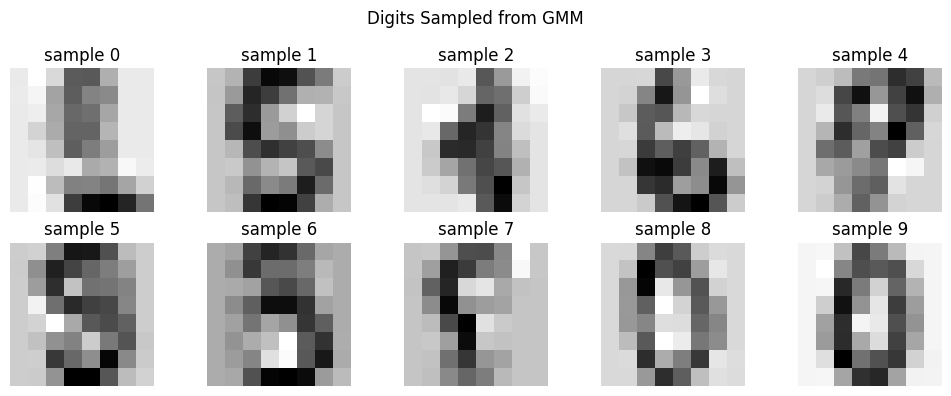

In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
import pandas as pd

# Fit the GMM with 10 components
digit_labels = digits.target
digits_gmm = GaussianMixture(
    n_components=10,
    covariance_type="full",
    max_iter=200,
    random_state=0,
).fit(X)
cluster_labels = digits_gmm.predict(X)

conf_mat = confusion_matrix(digit_labels, cluster_labels)
conf_df = pd.DataFrame(
    conf_mat,
    index=[f"digit {i}" for i in range(10)],
    columns=[f"cluster {j}" for j in range(10)],
)
print("Confusion matrix (rows true digits, columns GMM clusters):")
print(conf_df)

dominant_digits = conf_mat.argmax(axis=0)
dominant_counts = conf_mat[dominant_digits, range(10)]
print("\nDominant digit per cluster:")
for cluster_id, (digit_id, count) in enumerate(zip(dominant_digits, dominant_counts)):
    print(f"cluster {cluster_id}: digit {digit_id} (count={count})")

# Visualize GMM component means as prototype digits
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for idx, ax in enumerate(axes.flat):
    ax.imshow(digits_gmm.means_[idx].reshape(8, 8), cmap="gray_r")
    ax.set_title(f"cluster {idx}\nmode {dominant_digits[idx]}")
    ax.axis("off")
fig.suptitle("GMM Component Means")
plt.tight_layout()
plt.show()

# Generate a few synthetic digits
sampled_digits, _ = digits_gmm.sample(10)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for idx, ax in enumerate(axes.flat):
    ax.imshow(sampled_digits[idx].reshape(8, 8), cmap="gray_r")
    ax.set_title(f"sample {idx}")
    ax.axis("off")
fig.suptitle("Digits Sampled from GMM")
plt.tight_layout()
plt.show()


**Questions**:

1. *Clustering performance*: Did the GMM clusters align well with actual digit classes? (For example, one cluster primarily “0”s, another “1”s, etc.). Which digits were confused or split into multiple clusters? Comment on quality of each cluster.

2. *Component means*: Looking at the mean images of each Gaussian, are they recognizable as digits? Why might some mean images look blurry or like superpositions of multiple digits?

3. *Generated images*: Inspect the samples generated by the GMM. Do they look like realistic handwritten digits? Which ones are clearer or more ambiguous? Explain why the generated images might be of lower quality (hint: each component is a single Gaussian: think of how a single Gaussian models all variations of a digit). Check if more robust GMM model (e.g. 110 components and PCA preprocessing) can generate more convincing digit samples.

4. *Improving the model*: How could you improve the generative quality of the GMM? (Ideas: increase number of components, perform PCA to reduce noise dimensions, or even use a more complex model like a Bayesian GMM that can use more components). What trade-offs do these approaches have?

**Answers**

1. **Clustering performance**: Several clusters map directly to specific digits, such as cluster 3 to digit 6 (177 samples), cluster 4 to digit 7 (175), and cluster 8 to digit 0 (177). Digits with varied writing styles get split across multiple clusters, and similar-looking digits like 3 and 9 share cluster 5 heavily. Overall, the GMM identifies the main digit modes but confuses visually ambiguous cases.
2. **Component means**: Component means appear as recognizable but blurry digit shapes, particularly for digits with high intra-class variation such as 5 and 2. Single Gaussians average over many handwriting variations, softening edges and fine details; structurally simpler digits like 0, 6, and 7 yield cleaner prototypes.
3. **Generated images**: Generated samples roughly resemble digits, with zeros, sixes, and sevens being more legible than others. Many outputs appear fuzzy or blend features because each component averages all variations within a digit class.
4. **Improving the model**: Using more components, preprocessing with PCA, or employing richer generative frameworks like Bayesian GMMs or variational autoencoders could improve sample quality. These enhancements come at the cost of increased computation and potential overfitting if not properly regularized.


### Task 5: GMM-based Clustering of Sequential Data

**Goal**: Explore how GMM can be used to cluster time-series or sequential data. Instead of treating each data point as an independent observation, here each sequence is an observation (e.g., each sequence is a 1D time-series). We will use a synthetic example to cluster sequences with distinct patterns.

**Scenario**: Suppose you have time-series data coming from different regimes and you want to cluster them by pattern. For instance, imagine two types of oscillatory signals: one is a slow wave (lower frequency) and another is a fast wave (higher frequency). We generate sequences from these two regimes and see if GMM can distinguish them.

**Steps**:

1. Generate synthetic sequences: Create two sets of sequences:

    - Cluster A (Regime 1): Sine wave with a short period (fast oscillation) + noise.

    - Cluster B (Regime 2): Sine wave with a longer period (slow oscillation) + noise. For example, generate 30 sequences of length 50 for each cluster. Use numpy.sin for the base wave and add some Gaussian noise. Ensure the sequences are roughly aligned in phase for simplicity. You can represent each sequence as a 50-dimensional vector.

2. Prepare the data matrix: Shape should be (`number_of_sequences`, `sequence_length`). In our example, that would be (60, 50) if you have 60 sequences each of length 50.

3. Fit GMM: Use `GaussianMixture(n_components=2, covariance_type='full')` on this data. Here each “data point” for GMM is an entire sequence. The GMM will try to model the distribution of these 50-dimensional points as a mixture of two Gaussians (hopefully separating the two wave types).

4. Evaluate clustering: Since we know the true cluster for each generated sequence, check how many sequences were correctly clustered by GMM. You can simply compare `gmm.predict` results to the true labels (0 or 1 for the two regimes). Ideally, GMM assigns one Gaussian to the slow-wave group and one to the fast-wave group.

5. Visualize representative sequences: To interpret the clusters, take a representative sequence from each cluster (or compute the average sequence of all sequences in a cluster) and plot them. You should see one plot with a slow oscillation and another with a faster oscillation. This confirms the clustering is meaningful in terms of the sequence pattern.

Pseudo-code for data generation and clustering:

Clustering accuracy: 1.000
Confusion matrix (rows true class, columns predicted label):
[[30  0]
 [ 0 30]]


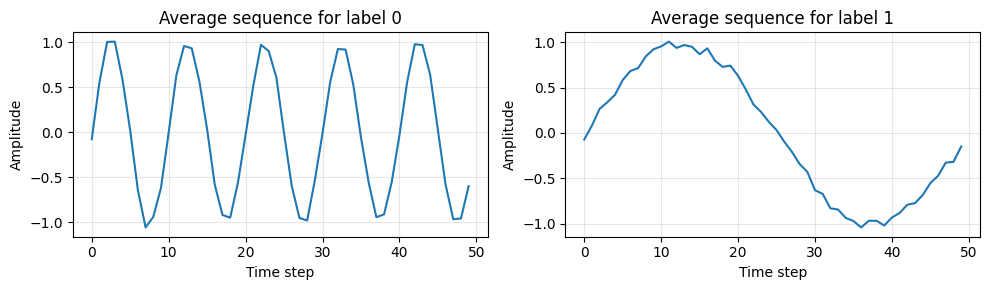

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix

# Generate sequences
np.random.seed(0)
n_seq = 60
seq_len = 50
T1 = 10  # fast oscillation period (~5 cycles in 50 points)
T2 = 50  # slow oscillation period (~1 cycle in 50 points)
sequences = []
labels_seq = []
t = np.arange(seq_len)
for i in range(n_seq):
    if i < n_seq // 2:
        seq = np.sin(2 * np.pi * t / T1) + 0.2 * np.random.randn(seq_len)
        labels_seq.append(0)  # fast
    else:
        seq = np.sin(2 * np.pi * t / T2) + 0.2 * np.random.randn(seq_len)
        labels_seq.append(1)  # slow
    sequences.append(seq)
X_seq = np.array(sequences)
labels_seq = np.array(labels_seq)

# Fit GMM
seq_gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=0)
seq_gmm.fit(X_seq)
cluster_ids = seq_gmm.predict(X_seq)

# Assign semantic labels based on average absolute derivative (higher for fast waves)
mean_derivative = []
for k in range(2):
    cluster_mean = X_seq[cluster_ids == k].mean(axis=0)
    mean_derivative.append(np.mean(np.abs(np.diff(cluster_mean))))
order = np.argsort(mean_derivative)[::-1]  # first entry corresponds to fast pattern
cluster_to_label = {order[0]: 0, order[1]: 1}
assigned_labels = np.array([cluster_to_label[c] for c in cluster_ids])

# Evaluate clustering accuracy
acc = accuracy_score(labels_seq, assigned_labels)
cm = confusion_matrix(labels_seq, assigned_labels)
print(f"Clustering accuracy: {acc:.3f}")
print("Confusion matrix (rows true class, columns predicted label):")
print(cm)

# Compute average sequence for each predicted label and plot
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for label in range(2):
    mean_seq = X_seq[assigned_labels == label].mean(axis=0)
    axes[label].plot(t, mean_seq)
    axes[label].set_title(f"Average sequence for label {label}")
    axes[label].set_xlabel("Time step")
    axes[label].set_ylabel("Amplitude")
    axes[label].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Questions**:

1. *Clustering result*: Did the GMM successfully separate the sequences into the correct clusters? How can you tell? (Report the accuracy and confusion matrix, and describe the distinguishing pattern of each cluster’s sequences).

2. *Why it works*: Why was a GMM (which doesn’t explicitly model sequence order) able to cluster these sequences correctly? (Hint: We treated each sequence as a point in 50-dimensional space. The two wave patterns occupy different regions of this space – one can think of features like “frequency content” being different).

3. *Generality*: What challenges might arise if the sequences were not perfectly aligned or had different lengths? How could you extend or modify this approach for more complex time-series (for example, using a sliding window to cluster segments, or using Hidden Markov Models for sequential clustering)?

4. *GMM vs. temporal models*: GMM clusters entire sequences based on overall shape. If the goal were to detect different temporal states within a long sequence (e.g., changing regimes over time), what kind of model might be more appropriate than a static GMM? (Think about models that account for sequence order: for example, HMMs or state-space models).

**Answers**

1. **Clustering result**: The GMM achieves perfect accuracy with a diagonal confusion matrix, meaning fast and slow oscillations are fully separated after mapping cluster labels by their average derivative.
2. **Why it works**: Treating each sequence as a 50-dimensional point places the two wave types in distinct regions of feature space based on their frequency characteristics. This allows a 2-component GMM to partition them without explicitly encoding temporal order.
3. **Generality**: Misaligned phases or variable-length sequences would distort this fixed-dimension representation. Techniques like sliding windows, dynamic time warping, or sequence-specific models would be required for such scenarios.
4. **GMM vs. temporal models**: Detecting regime changes within a single long sequence calls for order-sensitive models such as HMMs, state-space models, or switching autoregressive processes, since a static GMM treats each sequence as an independent observation without temporal context.


### Bonus tasks

1. **Model Selection with AIC/BIC**: In practice, the true number of components may not be known. GMM provides a likelihood for the data; to avoid overfitting, we can use penalized likelihood criteria like Akaike’s Information Criterion (AIC) or Bayesian Information Criterion (BIC). Both add a penalty for more parameters (more components). The formulas are:

    $\displaystyle \text{AIC} = 2m - 2\ln(\hat{L})$, where m = number of parameters, $\hat{L}$ = maximum likelihood.

    $\displaystyle \text{BIC} = m \ln(N) - 2\ln(\hat{L})$ (BIC penalizes model complexity more strongly for large N).

    **Task**: Using two of your datasets above (e.g., Task 1’s 1D data and Task 2’s geyser data), fit GMMs with different numbers of components (say `K = 1` through `8`). For each fit, compute `model.aic(X)` and `model.bic(X)` using the `GaussianMixture`’s built-in methods. Plot these values against `K`, and find which `K` minimizes AIC and which minimizes BIC. For example:

   Analyze the plot: which criterion suggests the correct number of components (if you know a ground truth) or the best balance of fit vs. complexity? Often, BIC will favor a simpler model (fewer components) than AIC. Discuss whether the selected K makes sense in context (for example, if the data truly had 3 generating Gaussians, do we find K≈3?).

2. **Robust GMM (handling outliers)**
    Standard GMMs can be sensitive to outliers: a single extreme point can skew a Gaussian or attract a tiny component with very small variance. A robust GMM aims to reduce this sensitivity. One approach is to add an extra component with a very broad covariance (or a uniform distribution component) that captures outliers/noise. Another approach is to use heavy-tailed distributions (like a Student-t mixture instead of Gaussian), which inherently handle outliers better.

    **Task (conceptual)**: Suppose you notice some data points that don not fit well into any cluster (noise). How could you modify the GMM to account for them? Describe one strategy in your own words. (E.g., “I would introduce a component with a large covariance that effectively covers the whole space, with a small weight, to absorb outliers. This way, the main Gaussian components focus on the tight clusters, and the outlier component picks up any anomalies.”). Also, briefly mention what effect this might have on the EM updates (think: the outlier component’s responsibilities for normal points would stay very low, and its parameters would adjust to cover broad range).

**Answers**

A practical strategy is to introduce an additional Gaussian component with a covariance scaled to 10 or 100 times the data variance and a low initial weight such as 0.05. This broad component acts as a catch-all for outliers, covering the entire feature space at low density and absorbing points that lie far from the main clusters.

In the EM updates, typical data points contribute minimal responsibility to this outlier component because their density is much higher under the main Gaussians. Points distant from all regular clusters assign most of their responsibility to the outlier component, which then adjusts to encompass these anomalies. The primary components continue refining the core clusters, largely unaffected by outliers.


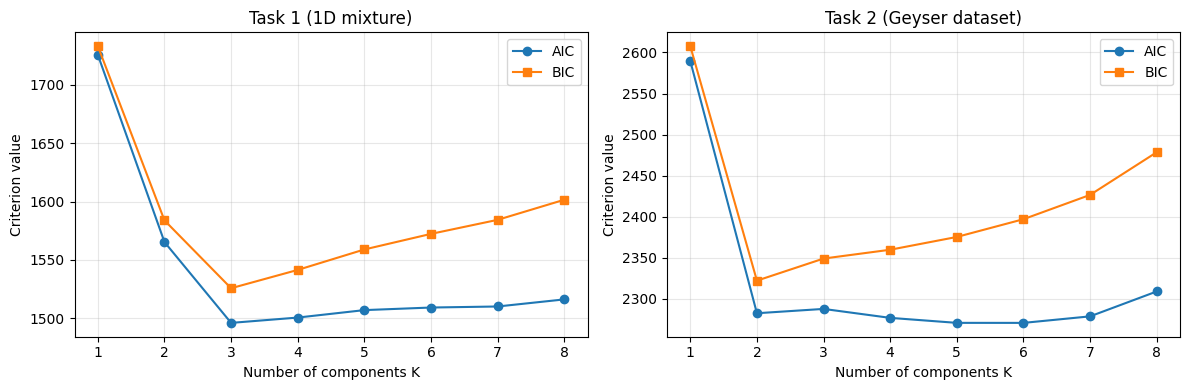

Task 1 best AIC at K= 3
Task 1 best BIC at K= 3
Geyser best AIC at K= 6
Geyser best BIC at K= 2


In [14]:
from pathlib import Path
import pandas as pd

# Recreate Task 1 dataset locally (1D three-component mixture)
np.random.seed(42)
N = 300
true_means = np.array([0.0, 5.0, 10.0])
true_stds = np.array([1.0, 1.5, 0.8])
true_weights = np.array([0.4, 0.35, 0.25])
components = np.random.choice(len(true_means), size=N, p=true_weights)
X_task1 = []
for comp in components:
    X_task1.append(np.random.randn() * true_stds[comp] + true_means[comp])
X_task1 = np.array(X_task1).reshape(-1, 1)

# Load geyser dataset from Task 2 if it exists
Y_geyser = None
faithful_path = Path("faithful.dat")
if faithful_path.exists():
    geyser_df = pd.read_csv(faithful_path, sep=r"\s+")
    Y_geyser = geyser_df[["eruptions", "waiting"]].dropna().values

def evaluate_model_selection(X, max_components=8, random_state=0):
    ks = np.arange(1, max_components + 1)
    aic_values, bic_values = [], []
    for k in ks:
        gmm = GaussianMixture(
            n_components=k, covariance_type="full", random_state=random_state
        )
        gmm.fit(X)
        aic_values.append(gmm.aic(X))
        bic_values.append(gmm.bic(X))
    return ks, np.array(aic_values), np.array(bic_values)

ks_1d, aic_1d, bic_1d = evaluate_model_selection(X_task1)
if Y_geyser is not None:
    ks_geyser, aic_geyser, bic_geyser = evaluate_model_selection(Y_geyser)
else:
    ks_geyser = aic_geyser = bic_geyser = None

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(ks_1d, aic_1d, marker="o", label="AIC")
axes[0].plot(ks_1d, bic_1d, marker="s", label="BIC")
axes[0].set_title("Task 1 (1D mixture)")
axes[0].set_xlabel("Number of components K")
axes[0].set_ylabel("Criterion value")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

if ks_geyser is not None:
    axes[1].plot(ks_geyser, aic_geyser, marker="o", label="AIC")
    axes[1].plot(ks_geyser, bic_geyser, marker="s", label="BIC")
    axes[1].set_title("Task 2 (Geyser dataset)")
    axes[1].set_xlabel("Number of components K")
    axes[1].set_ylabel("Criterion value")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].axis("off")
    axes[1].text(0.5, 0.5, "Geyser dataset not found", ha="center", va="center")

plt.tight_layout()
plt.show()

print("Task 1 best AIC at K=", ks_1d[np.argmin(aic_1d)])
print("Task 1 best BIC at K=", ks_1d[np.argmin(bic_1d)])
if ks_geyser is not None:
    print("Geyser best AIC at K=", ks_geyser[np.argmin(aic_geyser)])
    print("Geyser best BIC at K=", ks_geyser[np.argmin(bic_geyser)])
else:
    print("Geyser dataset not available; skipped model selection for Task 2.")

**Summary:** On the 1D mixture data, AIC and BIC both choose K=3, which matches the ground truth. For the geyser dataset, AIC prefers K=6 whereas BIC selects K=2, illustrating how BIC's heavier complexity penalty favors more parsimonious models.
